# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Arild Madshaven
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

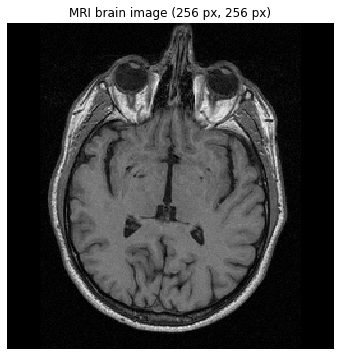

In [2]:
import skimage.io
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [3]:
def plotHist(im, dsc=''):
    im_h, im_w = im.shape
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.hist(im)
    ax.set_title(dsc+' ({} px, {} px)'.format(im_h, im_w))
    plt.show()

In [4]:
def plotIm(im, dsc='', scale=1):
    im_h, im_w = im.shape

    fig, ax = plt.subplots(1, 1, figsize=(6*scale, 6*scale))
    ax.imshow(im, cmap='gray')
    ax.set_title(dsc+' ({} px, {} px)'.format(im_h, im_w))
    ax.axis('off')
    plt.show()

In [5]:
def plotImComp(im1, im2, dsc='', scale=2):
    plotIm(np.concatenate((im1, im2), axis=1), dsc=dsc, scale=scale)

In [6]:
def thrsh(im, l_thr, u_thr, invert=False):
    trf = im.copy()
    if not invert:
        trf[trf < l_thr] = 0
        trf[u_thr < trf] = 255
    else:
        trf[trf < l_thr] = 255
        trf[u_thr < trf] = 0       
    return trf

In [7]:
def stretchHist(im, new_max):
    c = im.copy().astype('float64')
    min_val = c.min()
    max_val = c.max()
        
    c -= min_val
    c /= (max_val - min_val)
    
    return (c * new_max).astype('uint8')

#### First some mild neoising

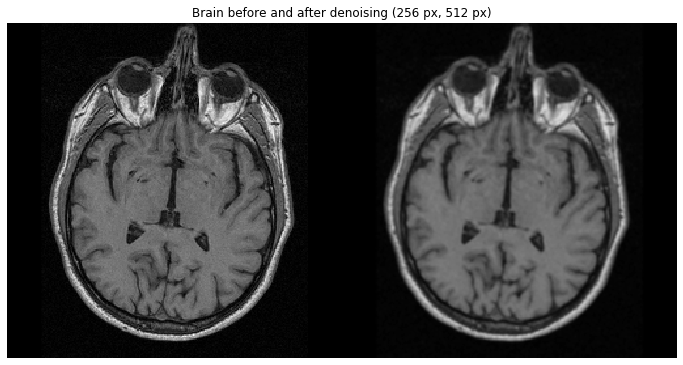

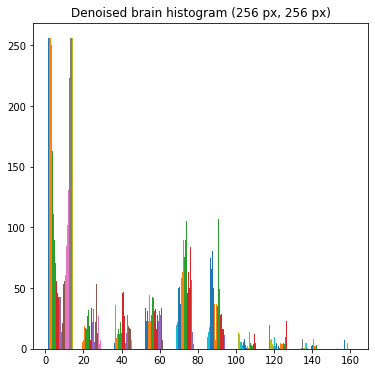

In [8]:
d_brain = cv2.GaussianBlur(brain_im, (3,3), 1)
plotImComp(brain_im, d_brain, 'Brain before and after denoising')
plotHist(d_brain, 'Denoised brain histogram')

#### Our brain tissue is light gray. 50 seems like a safe lower threshold to eliminate dark shades of gray.

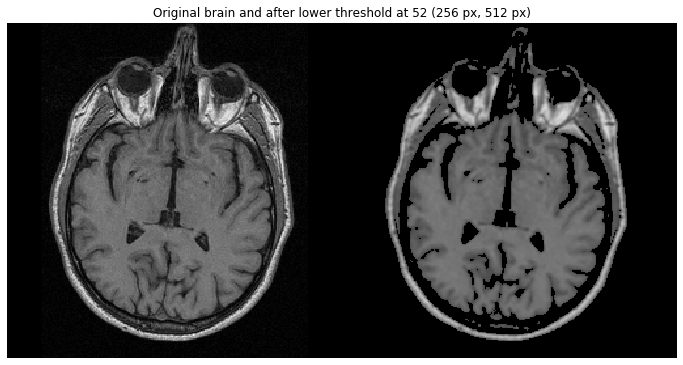

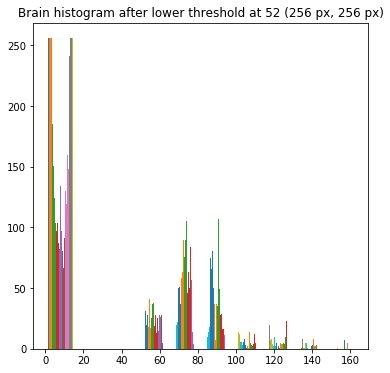

In [9]:
l_thr = 52
u_thr = 255
t_brain = thrsh(d_brain, l_thr, u_thr)
plotImComp(brain_im, t_brain, dsc=f'Original brain and after lower threshold at {l_thr}'), 
plotHist(t_brain, f'Brain histogram after lower threshold at {l_thr}')

#### The lightest shades are seemingly found in the skull surrounding the brain. 
Let's set the lightest shades to zero, say those above 91

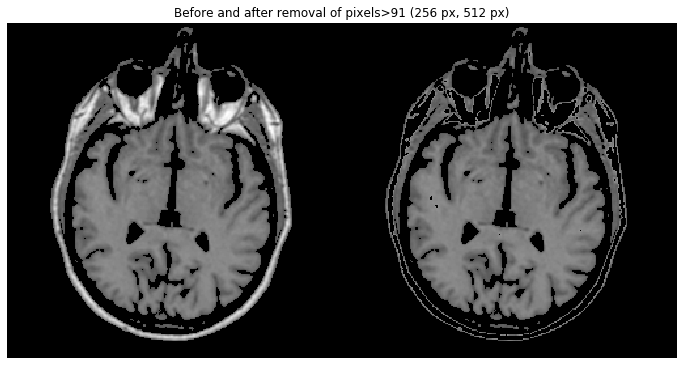

In [10]:
u_thr = 91
t1_brain = thrsh(t_brain, 0, u_thr, invert=True)
plotImComp(t_brain, t1_brain, f'Before and after removal of pixels>{u_thr}')

#### Notice weak edges connecting brain tissue to other stuff in the top right. Detach by opening

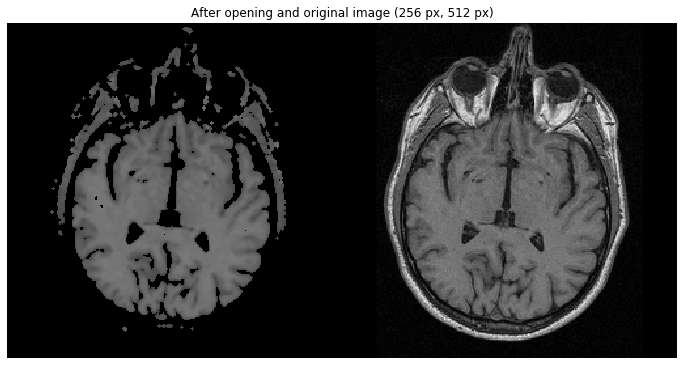

In [11]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
t1o_brain = cv2.morphologyEx(t1_brain, cv2.MORPH_OPEN, kernel)
plotImComp(t1o_brain, brain_im, 'After opening and original image')

#### The brain is a detached connex region. Hooray!

### 1.2 Region growing
Add your implementation and discussion

#### Helper fn. Returns all connex neighbours from one seed

In [62]:
def collectRegion(seed, im_arr, lower_threshold, upper_threshold):

    detected = set([seed])
    visited = set()

    x_min = y_min = 0
    x_max, y_max = im_arr.shape
    
    while len(detected):
        

        pix = detected.pop()
        if not (lower_threshold<im_arr[pix]<upper_threshold) or pix in visited: continue

        x, y = pix
        for xi in range(max(x-1, x_min), min(x+2, x_max), 2):
                if lower_threshold < im_arr[xi, y] < upper_threshold: detected.add((xi, y))
        for yi in range(max(y-1, y_min), min(y+2, y_max), 2):
                if lower_threshold < im_arr[x, yi] < upper_threshold: detected.add((x, yi))
        visited.add(pix)  
    
    return visited

In [63]:
def collectAllRegions(seeds, im, l_thr, u_thr):
    
    regions = []
    visited_pixels = set()

    for seed in seeds:
        if seed in visited_pixels: continue

        region = collectRegion(seed, im, l_thr, u_thr)
        
        regions.append(region)
        visited_pixels |= region
        
    return regions, visited_pixels

In [64]:
def idxOfLargestList(lst):
    max_s = max_i = 0
    for i in range(len(lst)):
        size = len(lst[i])
        if size > max_s:
            max_s = size
            max_i = i
    return max_i

In [65]:
def identifyLargestRegion(processed_im, original_im, l_thr, u_thr, seeds_grid_d):
    c = processed_im.copy()
    
    # Create grid of seeds. For the brain problem, we're looking for a large area so d could be set quite large
    
    seeds = set()

    d = seeds_grid_d
    for xi, row in enumerate(processed_im):
        for yi, val in enumerate(row):
            if not xi%d and not yi%d: seeds.add((xi, yi))  
                
    # Visualize seed pixels
    tp = c.copy()
    for pix in seeds: tp[pix] = 255
    plotIm(tp, f'Grid of seeds with d={d}')
    
    # Fetch all areas from seed points and visualize on original image
    
    regions, visited_pixels = collectAllRegions(seeds, c, l_thr, u_thr)
    tp = original_im.copy()
    for p in visited_pixels: tp[p] = 255
    plotIm(tp, 'All connex regions which satisfy criterion')
    
    # Fetch largest region 
    max_ri = idxOfLargestList(regions)
    
    # Visualize largest region
    c = original_im.copy()
    for p in regions[max_ri]: c[p] = 255
    plotImComp(c, original_im, 'Identified brain and original image')
    
    # Return list of indices to largest region
    return regions[max_ri]

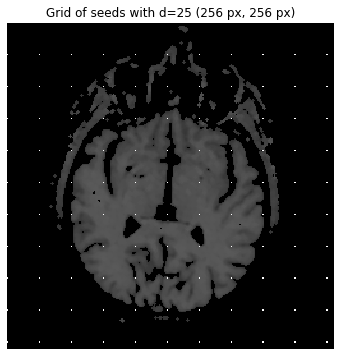

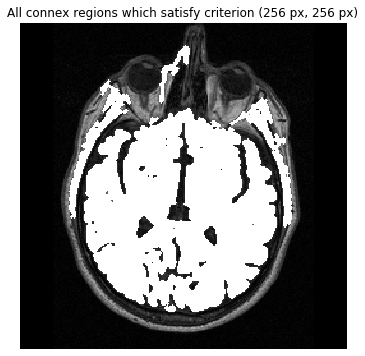

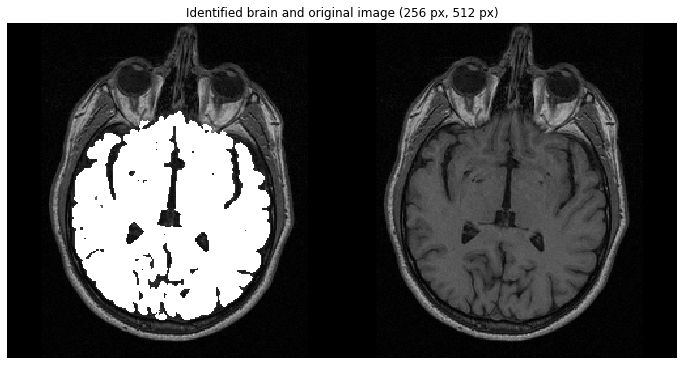

In [66]:
brain_pixel_indices = identifyLargestRegion(t1o_brain, brain_im, 2, 255, 25)

In [67]:
print(f"Brain size: {len(brain_pixel_indices)}")

Brain size: 16573


### Steal Theo's solution

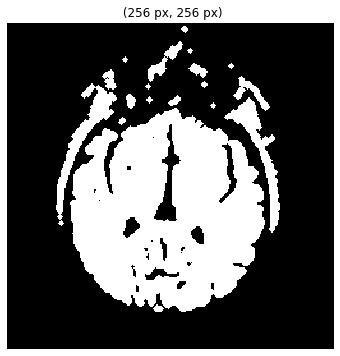

In [68]:
op = np.load('im_open.pkl.npy')
plotIm(op)

#### Identify single seed

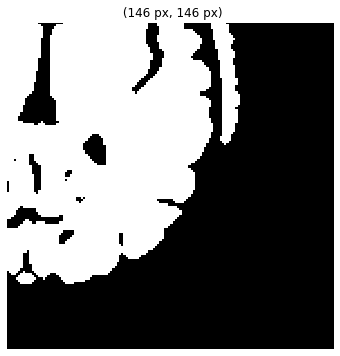

In [69]:
plotIm(op[110:, 110:])

In [70]:
seed = (110,110)
l_thr = op[seed] - 1
u_thr = op[seed] + 1

In [71]:
brain_pixels = collectRegion(seed, op, l_thr, u_thr)

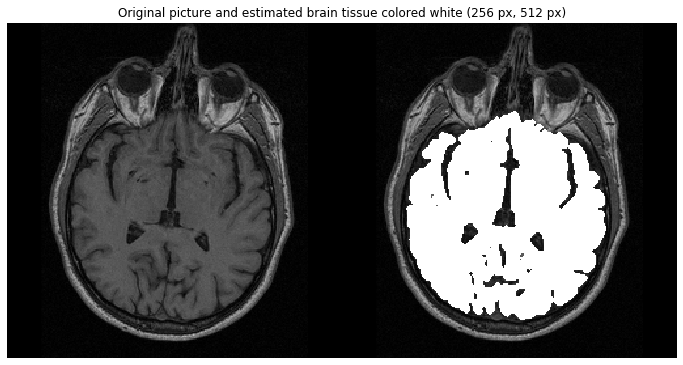

In [72]:
brain_im_cpy = brain_im.copy()
for pix in brain_pixels: brain_im_cpy[pix] = 255
plotImComp(brain_im, brain_im_cpy, 'Original picture and estimated brain tissue colored white')

In [73]:
print(f"Brain size: {len(brain_pixels)}")

Brain size: 16842


In [77]:
c = brain_im.copy()
for p in brain_pixel_indices: c[p]= 255

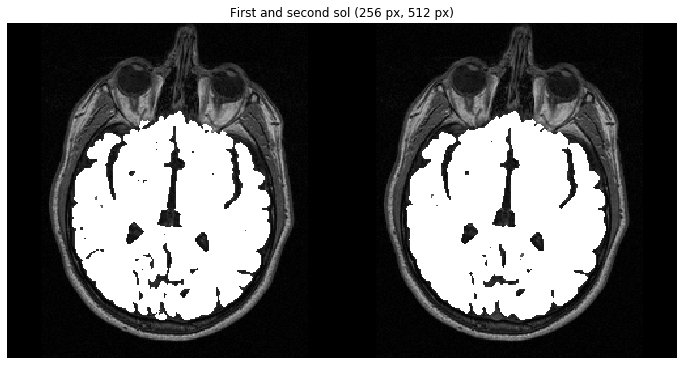

In [78]:
plotImComp(c, brain_im_cpy, 'First and second sol')

### 1.3 Contour detection
Add your implementation and discussion

#### Remember for discussion: 
[https://en.wikipedia.org/wiki/Edge_detection] The early Marr–Hildreth operator is based on the detection of zero-crossings of the Laplacian operator applied to a Gaussian-smoothed image. It can be shown, however, that this operator will also return false edges corresponding to local minima of the gradient magnitude. Moreover, this operator will give poor localization at curved edges. Hence, this operator is today mainly of historical interest.

In [79]:
def LoG(sigma, x, y):
    return -1/(np.pi * sigma**4)*np.exp(-(x**2+y**2)/(2*sigma**2))*(1 - (x**2+y**2)/(2*sigma**2))

In [80]:
from sklearn.preprocessing import normalize

In [81]:
def constructLoGKernel(sigma, size=7):
    assert size%2, 'Kernel must be odd'
    
    kernel = np.zeros((size,size))
    mid = size//2
    
    for y in range(-mid, mid+1):
        for x in range(-mid, mid+1):
            kernel[x+mid, y+mid] = LoG(sigma,x,y)
            
    kernel = normalize(kernel, axis=1, norm='l1')
    return kernel

In [82]:
def printKernel(k, dsc='',round_val=2):
    print(dsc)
    for row in k:
        for e in row: print(round(e, 2), end='\t')
        print()

#### Stretch histogram a bit to ease contour detection

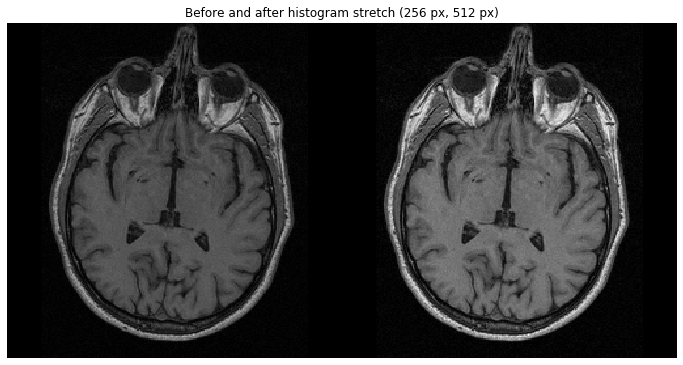

In [84]:
b = brain_im.copy()
b = stretchHist(b, 255)

plotImComp(brain_im, b, 'Before and after histogram stretch')

#### Apply Laplacian of Gaussian method

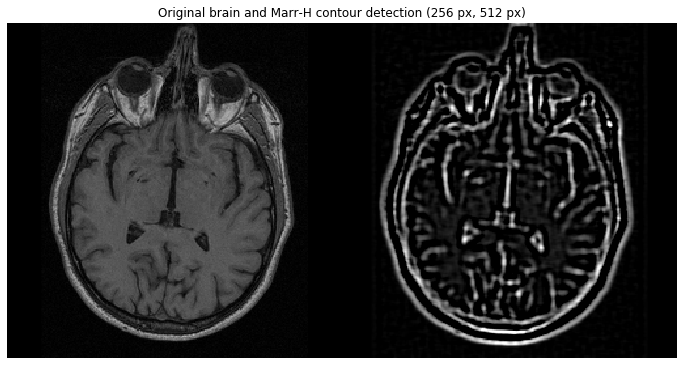

Marr-Hildreth kernel
0.09	0.12	0.13	0.12	0.11	0.12	0.13	0.12	0.09	
0.17	0.18	0.11	-0.01	-0.06	-0.01	0.11	0.18	0.17	
0.08	0.05	-0.06	-0.19	-0.25	-0.19	-0.06	0.05	0.08	
0.04	-0.0	-0.1	-0.22	-0.27	-0.22	-0.1	-0.0	0.04	
0.03	-0.01	-0.11	-0.22	-0.26	-0.22	-0.11	-0.01	0.03	
0.04	-0.0	-0.1	-0.22	-0.27	-0.22	-0.1	-0.0	0.04	
0.08	0.05	-0.06	-0.19	-0.25	-0.19	-0.06	0.05	0.08	
0.17	0.18	0.11	-0.01	-0.06	-0.01	0.11	0.18	0.17	
0.09	0.12	0.13	0.12	0.11	0.12	0.13	0.12	0.09	


In [85]:
sigma = 2.25 ## Larger sigma = more noise reduction
kernel_size = 9 ## Larger kernel = better approximation
LoG_kernel = constructLoGKernel(sigma, kernel_size)

brain_LoG = cv2.filter2D(b, -1, LoG_kernel) 
plotImComp(brain_im, brain_LoG, 'Original brain and Marr-H contour detection')
printKernel(LoG_kernel, 'Marr-Hildreth kernel')

#### Filter out weak edges

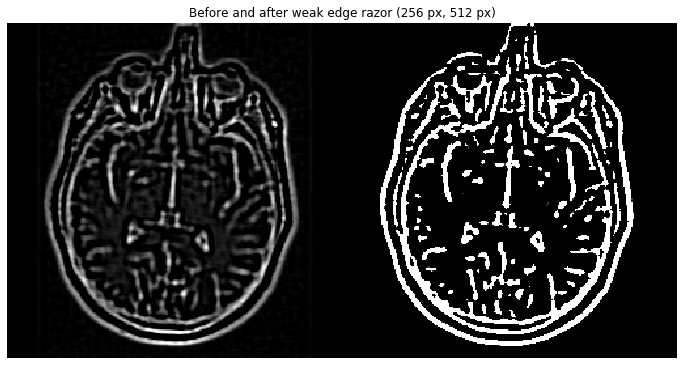

In [89]:
cpy = thrsh(brain_LoG, 60, 61)
plotImComp(brain_LoG, cpy, 'Before and after weak edge razor')

#### Do some closing to close edge surrounding brain

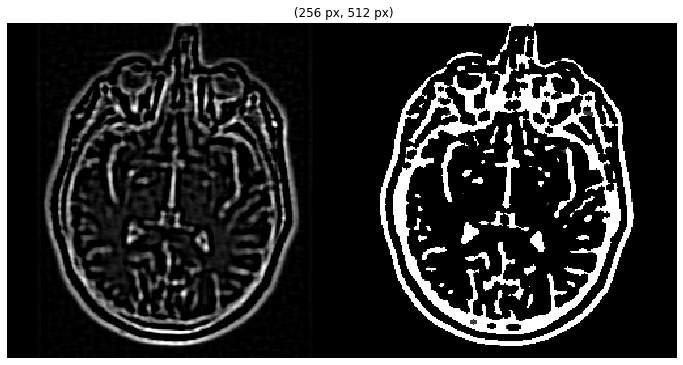

In [90]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
cpy = cv2.morphologyEx(cpy, cv2.MORPH_CLOSE, kernel)
plotImComp(brain_LoG, cpy)

#### Set background white and look for dark regions

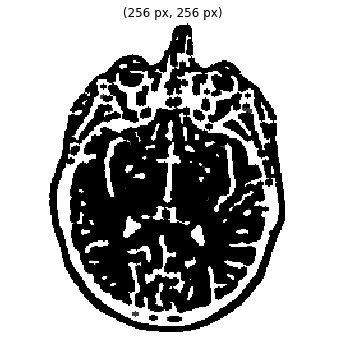

In [91]:
seed = (1,1)
bg = collectRegion(seed, b, -1, 40)
for pix in bg: cpy[pix] = 255
plotIm(cpy)

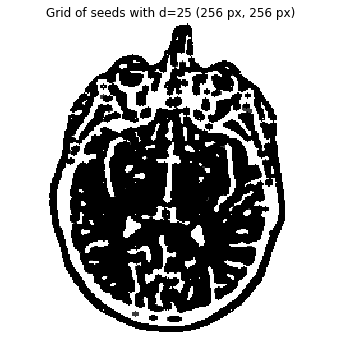

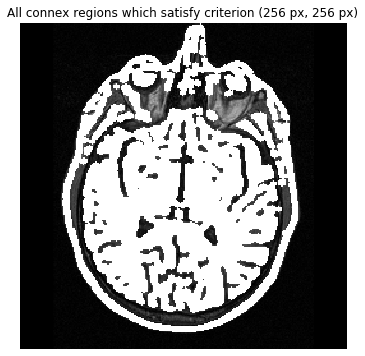

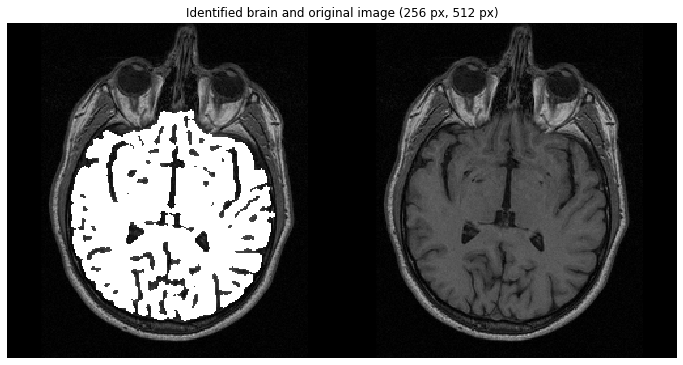

In [94]:
l_thr = -1
u_thr = 1
seed_grid_distance = 25
brain_contour = identifyLargestRegion(cpy, brain_im, l_thr, u_thr, seed_grid_distance)

In [93]:
print(f"Size of brain: {len(brain_contour)}")

Size of brain: 16015


### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [ ]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

In [ ]:
im0 = images[0]
im1 = images[1]
im2 = images[2]

In [ ]:
# go from pixel arrays [r, g, b] to b
im0_blue = np.array([[p[2] for p in r] for r in im0])
im1_blue = np.array([[p[2] for p in r] for r in im1])
im2_blue = np.array([[p[2] for p in r] for r in im2])

In [ ]:
def normalizeIntensity(im):
    max_val = im.max()
    min_val = im.min()
    im_cpy = im.copy()
    
    im_cpy = np.array([[int((e-min_val)/(max_val-min_val)*255) for e in r] for r in im_cpy])
    
    return im_cpy

In [ ]:
plotIm(im2_blue)
plt.hist(im2_blue)
plt.show()

In [ ]:
kernel = np.ones((5,5), np.float32)
kernel /= 5**2

im2_blue_blur = cv2.filter2D(im2_blue, -1, kernel)
plotIm(im2_blue_blur)
plt.hist(im2_blue_blur)
plt.show()

In [ ]:
c = normalizeIntensity(c)
plotIm(c)
plt.hist(c)
plt.show(c)

In [ ]:
plt.hist(c.flatten())
plt.show()

In [ ]:
bins, hist = np.histogram(c.flatten(), bins=256, range=(0, 256))

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion